# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# From facial_emotion_recogination 91% accuracy train set notebook
from keras.preprocessing.image import load_img
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
from keras.utils import plot_model

# Load the FER-2013 dataset

In [3]:
# Declarations

TRAIN_DIR = "/kaggle/input/fer2013/train/"
TEST_DIR  = "/kaggle/input/fer2013/test/"

IMG_SIZE = (48, 48)
CLASSES = 7
BATCH_SIZE = 64
EPOCHS = 50

## Image Counts

In [4]:
# Count images in each class

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
    
train_count = count_exp(TRAIN_DIR, 'train')
test_count = count_exp(TEST_DIR, 'test')

print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


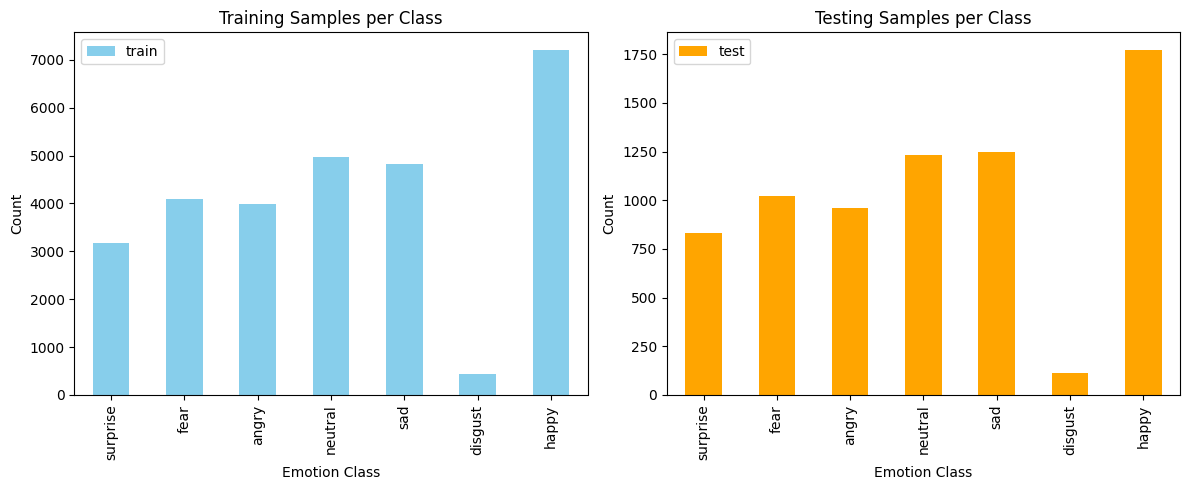

In [5]:
# Plot train and test counts

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train plot
train_count.transpose().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Training Samples per Class")
axes[0].set_xlabel("Emotion Class")
axes[0].set_ylabel("Count")

# Test plot
test_count.transpose().plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title("Testing Samples per Class")
axes[1].set_xlabel("Emotion Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## Create Data Generators

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

In [7]:
print("Train class indices:")
print(train_generator.class_indices)

print("\nTest class indices:")
print(test_generator.class_indices)

Train class indices:
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

Test class indices:
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Visualize Samples

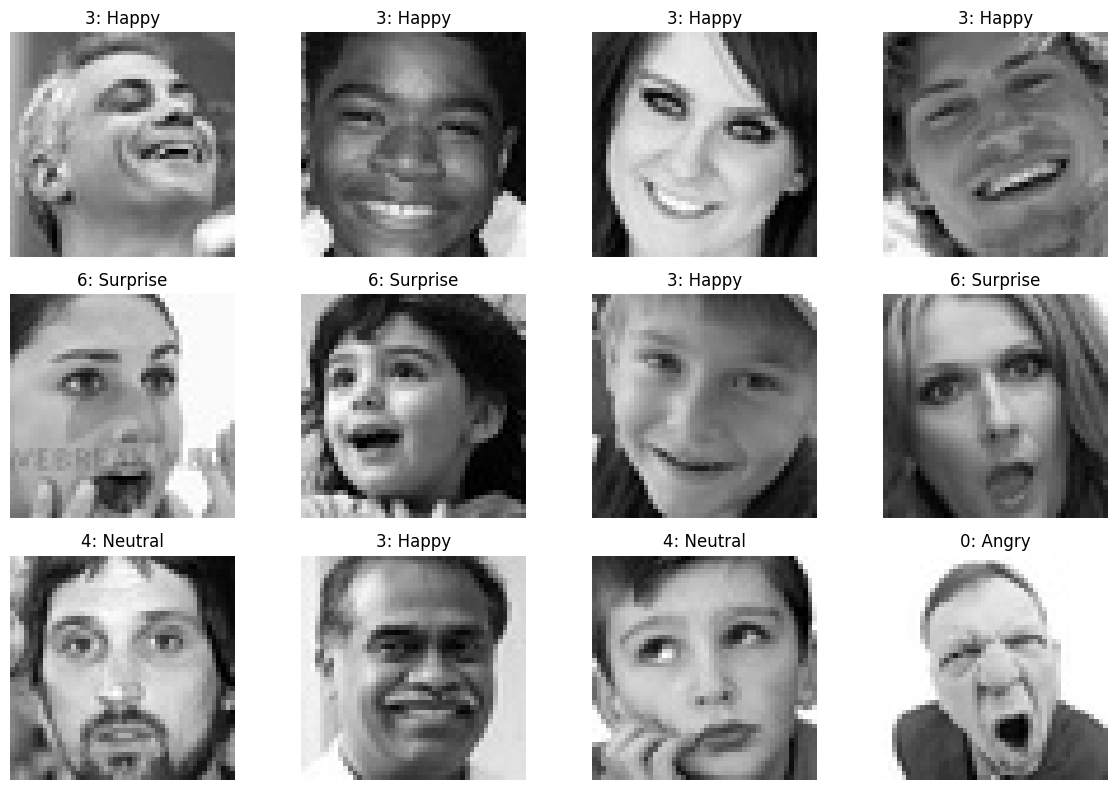

In [8]:
images, labels = next(train_generator)   # One batch
emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

plt.figure(figsize=(12, 8))

for i in range(12):  # show 12 images
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].reshape(IMG_SIZE), cmap='gray')
    label_index = labels[i].argmax()
    plt.title(f"{label_index}: {emotion_classes[label_index]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# CNN Model

## Define the Model

In [ ]:
def build_cnn_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    # Block 2
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    # Block 3
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    # Dense Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(CLASSES, activation='softmax'))

    return model

cnn_model_sgd = build_cnn_model()
cnn_model_adam = build_cnn_model()
cnn_model_adagrad = build_cnn_model()

In [ ]:
cnn_model_sgd.summary()

## Training the Models

In [ ]:
# Compile Model (SGD)
sgd = optimizers.SGD(learning_rate=0.01)

cnn_model_sgd.compile(
    optimizer=sgd,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Model (SGD)
history_sgd = cnn_model_sgd.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

In [ ]:
# Plot Training Curves (SGD)

# Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_sgd.history['accuracy'], label='Train Accuracy')
plt.plot(history_sgd.history['val_accuracy'], label='Val Accuracy')
plt.title('SGD - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_sgd.history['loss'], label='Train Loss')
plt.plot(history_sgd.history['val_loss'], label='Val Loss')
plt.title('SGD - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Compile Model (Adam)
adam = optimizers.Adam(learning_rate=0.001)

cnn_model_adam.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Model (Adam)
history_adam = cnn_model_adam.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

In [ ]:
# Plot Training Curves (Adam)

# Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_adam.history['accuracy'], label='Train Accuracy')
plt.plot(history_adam.history['val_accuracy'], label='Val Accuracy')
plt.title('Adam - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_adam.history['loss'], label='Train Loss')
plt.plot(history_adam.history['val_loss'], label='Val Loss')
plt.title('Adam - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Compile Model (Adagrad)
adagrad = optimizers.Adagrad(learning_rate=0.001)

cnn_model_adagrad.compile(
    optimizer=adagrad,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train Model (Adagrad)
history_adagrad = cnn_model_adagrad.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

In [ ]:
# Plot Training Curves (Adagrad)

# Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_adagrad.history['accuracy'], label='Train Accuracy')
plt.plot(history_adagrad.history['val_accuracy'], label='Val Accuracy')
plt.title('Adagrad - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_adagrad.history['loss'], label='Train Loss')
plt.plot(history_adagrad.history['val_loss'], label='Val Loss')
plt.title('Adagrad - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate Models

# Test accuracy (SGD)
test_loss_sgd, test_acc_sgd = cnn_model_sgd.evaluate(test_generator)
print(f"SGD Test Accuracy: {test_acc_sgd:.4f}")

# Test accuracy (ِAdam)
test_loss_adam, test_acc_adam = cnn_model_adam.evaluate(test_generator)
print(f"Adam Test Accuracy: {test_acc_adam:.4f}")

# Test accuracy (Adagrad)
test_loss_adagrad, test_acc_adagrad = cnn_model_adagrad.evaluate(test_generator)
print(f"Adagrad Test Accuracy: {test_acc_adagrad:.4f}")

In [ ]:
# Predictions and Classification Report

# Get predictions (SGD)
y_pred_sgd = cnn_model_sgd.predict(test_generator)
y_pred_sgd = y_pred_sgd.argmax(axis=1)

# Get predictions (Adam)
y_pred_adam = cnn_model_adam.predict(test_generator)
y_pred_adam = y_pred_adam.argmax(axis=1)

# Get predictions (Adagrad)
y_pred_adagrad = cnn_model_adagrad.predict(test_generator)
y_pred_adagrad = y_pred_adagrad.argmax(axis=1)

# True labels
y_true = test_generator.classes

print(f"SGD Classification Report:\n{classification_report(y_true, y_pred_sgd)}")
print(f"Adam Classification Report:\n{classification_report(y_true, y_pred_adam)}")
print(f"Adagrad Classification Report:\n{classification_report(y_true, y_pred_adagrad)}")

In [ ]:
# Confusion Matrix (SGD)
cm = confusion_matrix(y_true, y_pred_sgd)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("SGD Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Confusion Matrix (Adam)
cm = confusion_matrix(y_true, y_pred_adam)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Adam Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Confusion Matrix (Adagrad)
cm = confusion_matrix(y_true, y_pred_adagrad)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Adagrad Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### ResNet Model

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\mosta\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [6]:
TRAIN_DIR = os.path.join(path, "train/")
TEST_DIR  = os.path.join(path, "test/")

In [7]:
IMG_SIZE = (48, 48)
CLASSES = 7
BATCH_SIZE = 64
EPOCHS = 50

In [8]:
# ============================
# ResNet Data Generators
# ============================
path_fer = path
RESNET_IMG_SIZE = (96, 96)

from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen_resnet = train_datagen_resnet.flow_from_directory(
    TRAIN_DIR,
    target_size=RESNET_IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

test_gen_resnet = test_datagen_resnet.flow_from_directory(
    TEST_DIR,
    target_size=RESNET_IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
# ============================
# Build ResNet50 for FER
# ============================
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

def build_resnet_model():
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(96, 96, 3)
    )

    # Freeze backbone
    for layer in base_model.layers:
        layer.trainable = False
    # for layer in resnet_model.layers[-30:]:
    #     layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

resnet_model = build_resnet_model()
resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# ============================
# Compile ResNet Model
# ============================
resnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# ============================
# Train ResNet Model
# ============================
history_resnet = resnet_model.fit(
    train_gen_resnet,
    epochs=20,
    validation_data=test_gen_resnet
)

Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.3938 - loss: 1.5773 - val_accuracy: 0.4416 - val_loss: 1.4601
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - accuracy: 0.4323 - loss: 1.4961 - val_accuracy: 0.4610 - val_loss: 1.4171
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.4529 - loss: 1.4398 - val_accuracy: 0.4705 - val_loss: 1.3857
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.4644 - loss: 1.4092 - val_accuracy: 0.4806 - val_loss: 1.3618
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.4816 - loss: 1.3698 - val_accuracy: 0.4921 - val_loss: 1.3467
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.4954 - loss: 1.3334 - val_accuracy: 0.4968 - val_loss: 1.3305
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.5117 - loss: 1.2962 - val_accuracy: 0.5050 - val_loss: 1.3123
Epoch 9/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.5153 - loss: 1.2838 - 

In [16]:
# ============================
# Fine-tuning ResNet
# ============================
for layer in resnet_model.layers[-30:]:
    layer.trainable = True

resnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_resnet_finetune = resnet_model.fit(
    train_gen_resnet,
    epochs=10,
    validation_data=test_gen_resnet
)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.5484 - loss: 1.1954 - val_accuracy: 0.5194 - val_loss: 1.2842
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 55s 121ms/step - accuracy: 0.6575 - loss: 0.9249 - val_accuracy: 0.5444 - val_loss: 1.2436
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 99ms/step - accuracy: 0.6904 - loss: 0.8425 - val_accuracy: 0.5566 - val_loss: 1.2363
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - accuracy: 0.7295 - loss: 0.7489 - val_accuracy: 0.5648 - val_loss: 1.2460
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.7662 - loss: 0.6549 - val_accuracy: 0.5671 - val_loss: 1.2628
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.8008 - loss: 0.5680 - val_accuracy: 0.5712 - val_loss: 1.2813
Epoch 9/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.8345 - loss: 0.4870 - val_accuracy: 0.5722 - val_loss: 1.3340
Epoch 10/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - accuracy: 0.8653 - loss: 0.4053 

In [ ]:
# ============================
# Save model (Keras format)
# ============================
resnet_model.save("resnet_fer_model.keras")

In [9]:
from tensorflow.keras.models import load_model, Model

# Load trained FER ResNet
resnet_fer = load_model("resnet_fer_model.keras")

resnet_fer.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 24, 24,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 24, 24,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 24, 24,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 24, 24,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 24, 24,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 24, 24,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

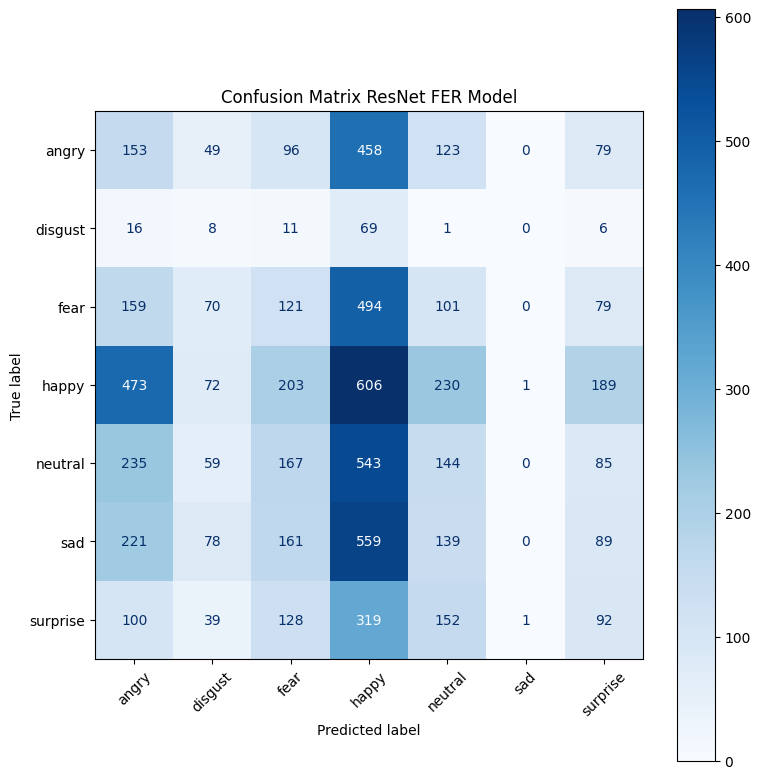

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred_probs = resnet_fer.predict(test_gen_resnet, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen_resnet.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_gen_resnet.class_indices.keys())
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix ResNet FER Model")
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_gen_resnet.class_indices.keys()))

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True
)

Found 7178 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [11]:
from tensorflow.keras.models import load_model, Model

# Load trained FER VGG
vgg_fer = load_model("vgg_model.keras")

vgg_fer.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │         1,79

 Total params: 29,697,168 (113.29 MB)

 Trainable params: 14,848,327 (56.64 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 14,848,329 (56.64 MB)

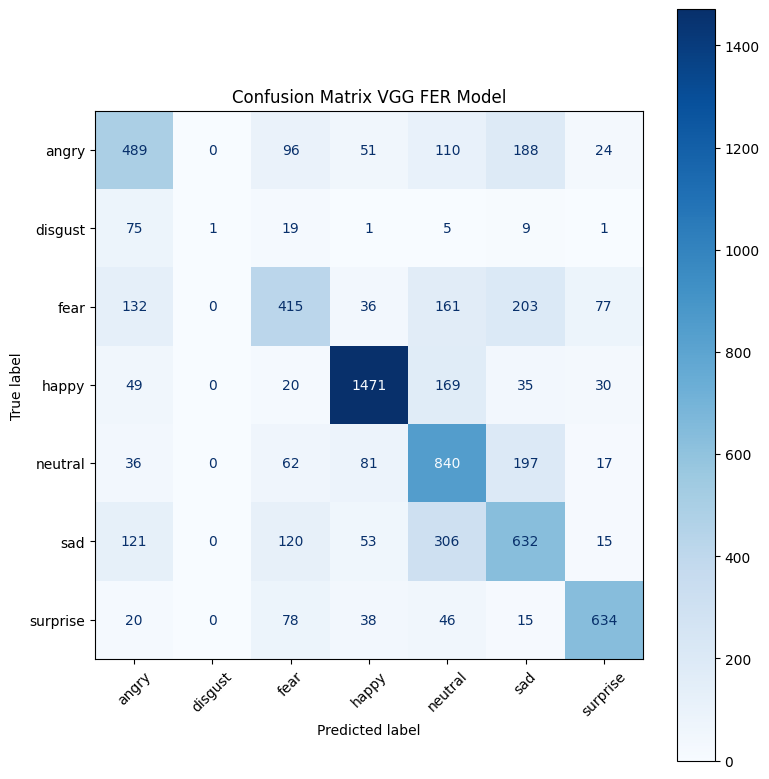

Classification Report:
              precision    recall  f1-score   support

       angry       0.53      0.51      0.52       958
     disgust       1.00      0.01      0.02       111
        fear       0.51      0.41      0.45      1024
       happy       0.85      0.83      0.84      1774
     neutral       0.51      0.68      0.59      1233
         sad       0.49      0.51      0.50      1247
    surprise       0.79      0.76      0.78       831

    accuracy                           0.62      7178
   macro avg       0.67      0.53      0.53      7178
weighted avg       0.64      0.62      0.62      7178



In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred_probs = vgg_fer.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix VGG FER Model")
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

In [16]:
import cv2
import numpy as np
import tensorflow as tf
from collections import deque
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import time

# --- CONFIG ---
CLASSES_NUM = 1280 # Output feature size of MobileNetV2 pooling='avg'
ACTION_LABELS = ['PushUps', 'Basketball', 'Haircut', 'WallPushups', 'Typing', 'WritingOnBoard']
ORIGINAL_LABELS = [
    'BabyCrawling', 'BodyWeightSquats', 'BoxingPunchingBag', 'BrushingTeeth', 
    'PushUps', 'ShavingBeard', 'BaseballPitch', 'Basketball', 'BlowDryHair', 
    'Haircut', 'Typing', 'WallPushups', 'WritingOnBoard'
]

WANTED_CLASSES = ['PushUps', 'Basketball', 'Haircut', 'WallPushups', 'Typing', 'WritingOnBoard']

ALLOWED_INDICES = [ORIGINAL_LABELS.index(label) for label in WANTED_CLASSES]
EMOTION_LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
FIXED_LEN = 20
IMG_SIZE = 224

# --- LOAD MODELS ---
feature_extractor = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
feature_extractor.trainable = False

emotion_model = tf.keras.models.load_model('vgg_model.keras')
emotion_model.load_weights('best_vgg.weights.h5') # Uncomment if needed

action_model = tf.keras.models.load_model('lstm_mobilenet.keras')
action_model.load_weights('SGDbest.weights.h5') # Uncomment if needed


# Store VECTORS (1280,), not IMAGES (224,224,3)
features_queue = deque(maxlen=FIXED_LEN)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def run_system():
    cap = cv2.VideoCapture(0)
    
    current_action = "Buffering..."
    current_emotion_label = ""
    frame_count = 0
    p_time = 0
    
    while True:
        ret, frame = cap.read()
        if not ret: break

        c_time = time.time()
        fps = 1 / (c_time - p_time) if (c_time - p_time) > 0 else 0
        p_time = c_time
        
        if frame_count % 3 == 0:
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = face_cascade.detectMultiScale(rgb_frame, 1.3, 5)

            if len(faces) == 0:
                current_emotion_label = ""

            for (x, y, w, h) in faces:
                roi_rgb = rgb_frame[y:y+h, x:x+w]

                # Resize image to 48x48 for VGG FER model
                roi_resized = cv2.resize(roi_rgb, (48, 48))

                # Rwesize image to 96x96 for ResNet FER model
                # roi_resized = cv2.resize(roi_rgb, (96, 96))

                roi_norm = roi_resized.astype('float32') / 255.0
                roi_expanded = np.expand_dims(roi_norm, axis=0)

                # Predict Emotion
                preds = emotion_model.predict(roi_expanded, verbose=0)
                current_emotion_label = EMOTION_LABELS[np.argmax(preds)]
                
                # We save coordinates to draw later
                last_face_coords = (x, y, w, h)
        
        # Draw the last known face emotion
        if current_emotion_label and 'last_face_coords' in locals():
            x, y, w, h = last_face_coords
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
            cv2.putText(frame, current_emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)
        
        resized = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        rgb_action = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        preprocessed = preprocess_input(rgb_action)
        img_expanded = np.expand_dims(preprocessed, axis=0) # Shape: (1, 224, 224, 3)

        current_features = feature_extractor.predict(img_expanded, verbose=0) # Shape: (1, 1280)
        
        features_queue.append(current_features.flatten()) # Store (1280,) vector

        if len(features_queue) == FIXED_LEN:
            seq = np.array(features_queue)
            seq_expanded = np.expand_dims(seq, axis=0)

            preds = action_model.predict(seq_expanded, verbose=0)[0] # Shape (13,)

            allowed_probs = preds[ALLOWED_INDICES]

            best_subset_index = np.argmax(allowed_probs)

            confidence = allowed_probs[best_subset_index]
            if confidence > 0.5:
                current_action = WANTED_CLASSES[best_subset_index]
            else:
                current_action = "Unknown"


        # if len(features_queue) == FIXED_LEN:
        #     seq = np.array(features_queue)
        #     seq_expanded = np.expand_dims(seq, axis=0)
            
        #     action_preds = action_model.predict(seq_expanded, verbose=0)
        #     current_action = ACTION_LABELS[np.argmax(action_preds)]

        cv2.putText(frame, f"Action: {current_action}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"FPS: {int(fps)}", (520, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
        cv2.imshow('Milestone 2', frame)
        
        frame_count += 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        if cv2.getWindowProperty('Milestone 2', cv2.WND_PROP_VISIBLE) < 1:
            break
            
    cap.release()
    cv2.destroyAllWindows()

run_system()